In [2]:
"""
Q1

OUYANG Hui
"""
import torch
import torch.nn as nn
import torchvision  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.optim as optim


In [3]:
"""
Load data
"""

# Download MNIST dataset 

transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,),(0.3081,))])

trainDataset = torchvision.datasets.MNIST( 
    root="./data", 
    train=True, 
    transform=transform, 
    download=True 
)

testDataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)


# Select only digit 0 and digit 7

dataset_0 = torch.cat((trainDataset.data[trainDataset.targets == 0], testDataset.data[testDataset.targets == 0]),0)/255
dataset_7 = torch.cat((trainDataset.data[trainDataset.targets == 7], testDataset.data[testDataset.targets == 7]),0)/255

dataset_0.shape, dataset_7.shape

(torch.Size([6903, 28, 28]), torch.Size([7293, 28, 28]))

Total number of bags: 121


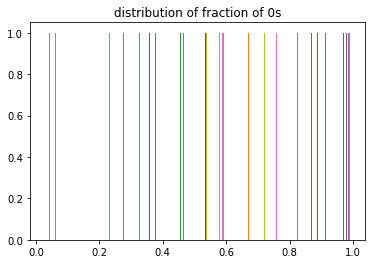

In [5]:
"""
Prepare the bags
"""
bag = []
label_set = []
bag_set = []
bag_size = 100
size_0 = size_7 = 0
len_0 = len(dataset_0)
len_7 = len(dataset_7)
num_0 = 0

# define the MNIST dataset where each smaple is a bag with corresponding label
class MNISTset(torch.utils.data.Dataset):
    def __init__(self, bag_set, label_set):
        self.bag = bag_set
        self.label = label_set
    
    def __getitem__(self, index):
        x, y = self.bag[index], self.label[index]
        return x, y
    
    def __len__(self):
        return len(self.bag)
                   
                   
while size_0 < len_0 and size_7 < len_7:
    num_0 = torch.randint(0, bag_size+1, (1,))[0]
    if size_0 + num_0 >= len_0 or size_7 + bag_size - num_0 >= len_7:
        break
    
    sample0 = dataset_0[slice(size_0, size_0 + num_0)]
    sample7 = dataset_7[slice(size_7, size_7 + (bag_size - num_0))]
    size_0 += num_0
    size_7 += (bag_size - num_0)
    bag = torch.cat((sample0, sample7),0).to(torch.float32)
    # shuffle the data
    index = [i for i in range(len(bag))]
    random.shuffle(index)
    bag = bag[index]
    bag_set.append(bag)
    # The bag will have a valve 0-1 as label representing the fracion of digit 0 in the bag
    label_set.append((num_0/100).to(torch.float32))

# generate the MNISET bags set for MIL
MNIST_set = MNISTset(bag_set, label_set)
print('Total number of bags: {}'.format(len(MNIST_set)))

# distribution of 0s
plt.title("distribution of fraction of 0s")
plt.hist(label_set)
plt.show()

In [6]:
"""
Split the data to training, validation, testing sets
"""

dataset_size = len(bag_set)
train_size = int(0.7 * dataset_size)
valid_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(MNIST_set, (train_size, valid_size, test_size))

len(train_dataset), len(valid_dataset), len(test_dataset)

(84, 24, 13)

In [7]:
"""
Feature extractor using ResNet 18

refer to : https://github.com/onermustafaumit/SRTPMs/blob/main/LUAD/mil_dpf_regression/resnet_no_bn.py

"""
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
		   'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
		   'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
	'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
	'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
	'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
	'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
	'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
	'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
	'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
	'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
	'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
	"""3x3 convolution with padding"""
	return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
					 padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
	"""1x1 convolution"""
	return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
	expansion = 1
	__constants__ = ['downsample']

	def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
				 base_width=64, dilation=1, norm_layer=None):
		super(BasicBlock, self).__init__()
		if norm_layer is None:
			norm_layer = nn.BatchNorm2d
		if groups != 1 or base_width != 64:
			raise ValueError('BasicBlock only supports groups=1 and base_width=64')
		if dilation > 1:
			raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
		# Both self.conv1 and self.downsample layers downsample the input when stride != 1
		self.conv1 = conv3x3(inplanes, planes, stride)
		# self.bn1 = norm_layer(planes)
		self.relu = nn.ReLU(inplace=True)
		self.conv2 = conv3x3(planes, planes)
		# self.bn2 = norm_layer(planes)
		self.downsample = downsample
		self.stride = stride

	def forward(self, x):
		identity = x

		out = self.conv1(x)
		# out = self.bn1(out)
		out = self.relu(out)

		out = self.conv2(out)
		# out = self.bn2(out)

		if self.downsample is not None:
			identity = self.downsample(x)

		out += identity
		out = self.relu(out)

		return out


class Bottleneck(nn.Module):
	expansion = 4
	__constants__ = ['downsample']

	def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
				 base_width=64, dilation=1, norm_layer=None):
		super(Bottleneck, self).__init__()
		if norm_layer is None:
			norm_layer = nn.BatchNorm2d
		width = int(planes * (base_width / 64.)) * groups
		# Both self.conv2 and self.downsample layers downsample the input when stride != 1
		self.conv1 = conv1x1(inplanes, width)
		self.bn1 = norm_layer(width)
		self.conv2 = conv3x3(width, width, stride, groups, dilation)
		self.bn2 = norm_layer(width)
		self.conv3 = conv1x1(width, planes * self.expansion)
		self.bn3 = norm_layer(planes * self.expansion)
		self.relu = nn.ReLU(inplace=True)
		self.downsample = downsample
		self.stride = stride

	def forward(self, x):
		identity = x

		out = self.conv1(x)
		out = self.bn1(out)
		out = self.relu(out)

		out = self.conv2(out)
		out = self.bn2(out)
		out = self.relu(out)

		out = self.conv3(out)
		out = self.bn3(out)

		if self.downsample is not None:
			identity = self.downsample(x)

		out += identity
		out = self.relu(out)

		return out


class ResNet(nn.Module):

	def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
				 groups=1, width_per_group=64, replace_stride_with_dilation=None,
				 norm_layer=None):
		super(ResNet, self).__init__()
		if norm_layer is None:
			norm_layer = nn.BatchNorm2d
		self._norm_layer = norm_layer

		self.inplanes = 64
		self.dilation = 1
		if replace_stride_with_dilation is None:
			# each element in the tuple indicates if we should replace
			# the 2x2 stride with a dilated convolution instead
			replace_stride_with_dilation = [False, False, False]
		if len(replace_stride_with_dilation) != 3:
			raise ValueError("replace_stride_with_dilation should be None "
							 "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
		self.groups = groups
		self.base_width = width_per_group
		self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
							   bias=False)
		# self.bn1 = norm_layer(self.inplanes)
		self.relu = nn.ReLU(inplace=True)
		self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
		self.layer1 = self._make_layer(block, 64, layers[0])
		self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
									   dilate=replace_stride_with_dilation[0])
		self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
									   dilate=replace_stride_with_dilation[1])
		self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
									   dilate=replace_stride_with_dilation[2])
		self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
		self.fc = nn.Linear(512 * block.expansion, num_classes)

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				# nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
				nn.init.xavier_uniform_(m.weight)
			elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)

		# Zero-initialize the last BN in each residual branch,
		# so that the residual branch starts with zeros, and each residual block behaves like an identity.
		# This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
		if zero_init_residual:
			for m in self.modules():
				if isinstance(m, Bottleneck):
					nn.init.constant_(m.bn3.weight, 0)
				elif isinstance(m, BasicBlock):
					nn.init.constant_(m.bn2.weight, 0)

	def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
		norm_layer = self._norm_layer
		downsample = None
		previous_dilation = self.dilation
		if dilate:
			self.dilation *= stride
			stride = 1
		if stride != 1 or self.inplanes != planes * block.expansion:
			downsample = nn.Sequential(
				conv1x1(self.inplanes, planes * block.expansion, stride),
				# norm_layer(planes * block.expansion),
			)

		layers = []
		layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
							self.base_width, previous_dilation, norm_layer))
		self.inplanes = planes * block.expansion
		for _ in range(1, blocks):
			layers.append(block(self.inplanes, planes, groups=self.groups,
								base_width=self.base_width, dilation=self.dilation,
								norm_layer=norm_layer))

		return nn.Sequential(*layers)

	def _forward_impl(self, x):
		# See note [TorchScript super()]
		x = self.conv1(x)
		# x = self.bn1(x)
		x = self.relu(x)
		x = self.maxpool(x)

		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)

		x = self.avgpool(x)
		x = torch.flatten(x, 1)
		x = self.fc(x)

		return x

	def forward(self, x):
		return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
	model = ResNet(block, layers, **kwargs)
	if pretrained:
		state_dict = load_state_dict_from_url(model_urls[arch],
											  progress=progress)
		model.load_state_dict(state_dict)
	return model


def resnet18(pretrained=False, progress=True, **kwargs):
	r"""ResNet-18 model from
	`"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

	Args:
		pretrained (bool): If True, returns a model pre-trained on ImageNet
		progress (bool): If True, displays a progress bar of the download to stderr
	"""
	return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
				   **kwargs)



In [8]:
"""
MIL pooling filter 

refer to : https://github.com/onermustafaumit/SRTPMs/blob/main/LUAD/mil_dpf_regression/distribution_pooling_filter.py

"""

class DistributionPoolingFilter(nn.Module):
	r"""Applies 'distribution' pooling as described in the paper
	`Weakly Supervised Clustering by Exploiting Unique Class Count`_ .
	We have a mini-batch of data Input: :math:`(B, N, J)`, where :math:`B` is number of bags, 
	:math:`N` is number of instances 
	in a bag, :math:`J` is number of extracted features from each instance in a bag.
	Given a bag :math:`X` with :math:`N` instances in the mini-batch, 
	for each instance :math:`x_i \in X`, we have :math:`J` extracted features 
	:math:`[f_{x_i}^j | f_{x_i}^j \in \mathbb{R}, j=1,2, \cdots, J] =\mathbf{f}_{x_i} \in \mathbb{R}^J`.
	Let :math:`\tilde{p}^j_{X}(v)` be the estimated marginal distribution of :math:`j^{th}` feature.
	Estimated marginal distribution :math:`\tilde{p}^j_{X}(v)` is obtained by using kernel 
	density estimation, which employs a Gaussian kernel with standard deviation :math:`\sigma`:
	.. math::
		\tilde{p}^j_{X}(v) = \frac{1}{N} \sum_{i=1}^{N}\frac{1}{\sqrt{2\pi{\sigma}^2}} e^{-\frac{1}{2{\sigma}^2} \left(v- f_{x_i}^{j}\right)^2} \ \forall_{j=1,2,\cdots,J}
	Then, the estimated marginal distribution :math:`\tilde{p}^j_{X}(v)` is sampled with :math:`M` bins:
	.. math::
		h^j_{X} = \left[ \tilde{p}^j_{X}(v=v_b) \ | \ v_b=\frac{b}{M-1} \text{ and } b=0,1,\cdots,M-1 \right] \ \forall_{j=1,2,\cdots,J}  \text{ where } h^j_{X} \in \mathbb{R}^M
	.. note::
		Sampling of the estimated distribution is done in the interval of :math:`[0,1]`. Hence, 
		for proper operation Input should be in the interval of :math:`[0,1]`.
	Bag level representation:
	.. math::
		\mathbf{h}_{X} = [h^j_{X} \ | \ h^j_{X} \in \mathbb{R}^M, j=1,2,\cdots,J] \in \mathbb{R}^{MJ}
	Finally, Output: :math:`(B, J, M)` consists of bag level representations of the bags in mini-batch.
	Args:
		num_bins: :math:`M`, number of bins to sample estimated marginal distributions.
			Default: 21
		sigma: :math:`\sigma`, standard deviation of Gaussian kernel.
			Default: 0.0167
	Shape:
		- Input: :math:`(B, N, J)`
		- Output: :math:`(B, J, M)`
	Examples::
		>>> input = torch.normal(0.5, 0.1, (1,200,1))
		>>> print(input.size())
		torch.Size([1, 200, 1])
		>>> m = DistributionPoolingFilter(21,0.0167)
		>>> output = m(input)
		>>> print(output.size())
		torch.Size([1, 1, 21])
		>>> print(output)
		tensor([[[7.7092e-36, 8.8147e-22, 1.2893e-11, 2.4122e-05, 5.8514e-03,
		          1.9012e-02, 3.0407e-02, 6.2145e-02, 1.1265e-01, 1.6227e-01,
		          1.9503e-01, 1.8669e-01, 1.1016e-01, 7.9186e-02, 2.5840e-02,
		          1.0619e-02, 1.0948e-04, 2.4347e-10, 7.0687e-20, 2.6271e-33,
		          0.0000e+00]]])
	.. _`Weakly Supervised Clustering by Exploiting Unique Class Count`:
		https://arxiv.org/abs/1906.07647
	"""


	__constants__ = ['num_bins', 'sigma']

	def __init__(self, num_bins=21, sigma=0.0167):
		super(DistributionPoolingFilter, self).__init__()

		self.num_bins = num_bins
		self.sigma = sigma
		self.alfa = 1/math.sqrt(2*math.pi*(sigma**2))
		self.beta = -1/(2*(sigma**2))

		sample_points = torch.linspace(0,1,steps=num_bins, dtype=torch.float32, requires_grad=False)
		self.register_buffer('sample_points', sample_points)


	def extra_repr(self):
		return 'num_bins={}, sigma={}'.format(
			self.num_bins, self.sigma
		)


	def forward(self, data):
		batch_size, num_instances, num_features = data.size()

		sample_points = self.sample_points.repeat(batch_size,num_instances,num_features,1)
		# sample_points.size() --> (batch_size,num_instances,num_features,num_bins)

		data = torch.reshape(data,(batch_size,num_instances,num_features,1))
		# data.size() --> (batch_size,num_instances,num_features,1)

		diff = sample_points - data.repeat(1,1,1,self.num_bins)
		diff_2 = diff**2
		# diff_2.size() --> (batch_size,num_instances,num_features,num_bins)

		result = self.alfa * torch.exp(self.beta*diff_2)
		# result.size() --> (batch_size,num_instances,num_features,num_bins)

		out_unnormalized = torch.sum(result,dim=1)
		# out_unnormalized.size() --> (batch_size,num_features,num_bins)

		norm_coeff = torch.sum(out_unnormalized, dim=2, keepdim=True)
		# norm_coeff.size() --> (batch_size,num_features,1)

		out = out_unnormalized / norm_coeff
		# out.size() --> (batch_size,num_features,num_bins)
		
		return out


In [9]:
"""
Representation transformation 

refer to : https://github.com/onermustafaumit/SRTPMs/blob/main/LUAD/mil_dpf_regression/model.py

"""
class FeatureExtractor(nn.Module):

	def __init__(self, num_features=32):
		super(FeatureExtractor, self).__init__()

		self._model_conv = resnet18()
		
		num_ftrs = self._model_conv.fc.in_features
		self._model_conv.fc = nn.Linear(num_ftrs, num_features)
		# print(self._model_conv)

		# self.sigmoid = nn.Sigmoid()
		self.relu = nn.ReLU()

	def forward(self, x):
		out = self._model_conv(x)
		# out = self.sigmoid(out)
		out = self.relu(out)
		# out = torch.clamp(out, min=0., max=1.)

		return out

class RepresentationTransformation(nn.Module):
	def __init__(self, num_features=32, num_bins=11, num_classes=10):
		super(RepresentationTransformation, self).__init__()

		self.fc = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(num_features * num_bins, 384),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(384, 192),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(192, num_classes)
			)

	def forward(self, x):

		out = self.fc(x)

		return out

class Model(nn.Module):

	def __init__(self, num_classes=10, num_instances=32, num_features=32, num_bins=11, sigma=0.1):
		super(Model, self).__init__()
		self._num_classes = num_classes
		self._num_instances = num_instances
		self._num_features = num_features
		self._num_bins = num_bins
		self._sigma = sigma

		# feature extractor module
		self._feature_extractor = FeatureExtractor(num_features=num_features)

		# MIL pooling filter
		self._mil_pooling_filter = DistributionPoolingFilter(num_bins=num_bins, sigma=sigma)

		# bag-level representation transformation module
		self._representation_transformation = RepresentationTransformation(num_features=num_features, num_bins=num_bins, num_classes=num_classes)


	def forward(self, x):

		out = self._feature_extractor(x)
		out = torch.reshape(out,(-1,self._num_instances,self._num_features))

		out = self._mil_pooling_filter(out)
		out = torch.flatten(out, 1)

		out = self._representation_transformation(out)

		return out


In [10]:
"""
Dataloaders
"""
BATCH_SIZE = 1

train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
)
valid_dataset_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True,
)
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True,
)


In [13]:
"""
Train the MIL model
"""
# initialize the parameters
epochs = 12
lr = 0.0001

# construct model
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=1, num_instances=100, num_features=28, num_bins=10, sigma=0.1)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)

# define loss criterion
criterion = torch.nn.L1Loss()

train_loss_list = []
validation_loss_list = []

for epoch in range(epochs):
    # train for one epoch
    print('############## EPOCH - {} ##############'.format(epoch+1))
    training_loss = 0
    validation_loss = 0
   
    print('******** training ********')
    num_predictions = 0
    model.train()    
    for bag, label in tqdm(train_dataset_loader):
        # reshape the MNIST data to 3-chanel
        bag = bag.squeeze(0)
        bag = torch.stack((bag, bag, bag), axis=1)
        bag = bag.to(device)
        label = label.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_logits = model(bag)
        loss = criterion(y_logits, label)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()*len(label)
        num_predictions += len(label)
        #print(y_logits, loss, num_predictions)
        
    training_loss /= num_predictions
    train_loss_list.append(training_loss)
    # evaluate on the validation dataset
    print('******** validation ********')
    num_predictions = 0
    model.eval()
    for bag, label in tqdm(valid_dataset_loader):
        with torch.no_grad():
            # reshape the MNIST data to 3-chanel
            bag = bag.squeeze(0)
            bag = torch.stack((bag, bag, bag), axis=1)            
            bag = bag.to(device)
            label = label.to(device)       

            # forward
            y_logits = model(bag)
            loss = criterion(y_logits, label)
            validation_loss += loss.item()*len(label)
            num_predictions += len(label)

    validation_loss /= num_predictions   
    validation_loss_list.append(validation_loss)
    
    print('Epoch=%d ### training_loss=%5.3f ### validation_loss=%5.3f' % (epoch+1, training_loss, validation_loss))

############## EPOCH - 1 ##############
******** training ********


100%|██████████| 84/84 [01:30<00:00,  1.08s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  7.46it/s]


Epoch=1 ### training_loss=0.482 ### validation_loss=0.328
############## EPOCH - 2 ##############
******** training ********


100%|██████████| 84/84 [01:27<00:00,  1.04s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  6.37it/s]


Epoch=2 ### training_loss=0.287 ### validation_loss=0.236
############## EPOCH - 3 ##############
******** training ********


100%|██████████| 84/84 [01:33<00:00,  1.12s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  6.20it/s]


Epoch=3 ### training_loss=0.284 ### validation_loss=0.234
############## EPOCH - 4 ##############
******** training ********


100%|██████████| 84/84 [01:26<00:00,  1.04s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  6.75it/s]


Epoch=4 ### training_loss=0.240 ### validation_loss=0.234
############## EPOCH - 5 ##############
******** training ********


100%|██████████| 84/84 [01:26<00:00,  1.03s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  7.01it/s]


Epoch=5 ### training_loss=0.266 ### validation_loss=0.222
############## EPOCH - 6 ##############
******** training ********


100%|██████████| 84/84 [01:30<00:00,  1.07s/it]


******** validation ********


100%|██████████| 24/24 [00:04<00:00,  5.83it/s]


Epoch=6 ### training_loss=0.224 ### validation_loss=0.207
############## EPOCH - 7 ##############
******** training ********


100%|██████████| 84/84 [01:29<00:00,  1.06s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  6.29it/s]


Epoch=7 ### training_loss=0.195 ### validation_loss=0.160
############## EPOCH - 8 ##############
******** training ********


100%|██████████| 84/84 [01:35<00:00,  1.14s/it]


******** validation ********


100%|██████████| 24/24 [00:04<00:00,  4.85it/s]


Epoch=8 ### training_loss=0.199 ### validation_loss=0.181
############## EPOCH - 9 ##############
******** training ********


100%|██████████| 84/84 [01:30<00:00,  1.07s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  7.04it/s]


Epoch=9 ### training_loss=0.190 ### validation_loss=0.126
############## EPOCH - 10 ##############
******** training ********


100%|██████████| 84/84 [01:39<00:00,  1.18s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  6.56it/s]


Epoch=10 ### training_loss=0.184 ### validation_loss=0.175
############## EPOCH - 11 ##############
******** training ********


100%|██████████| 84/84 [01:34<00:00,  1.12s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  6.56it/s]


Epoch=11 ### training_loss=0.181 ### validation_loss=0.110
############## EPOCH - 12 ##############
******** training ********


100%|██████████| 84/84 [01:28<00:00,  1.06s/it]


******** validation ********


100%|██████████| 24/24 [00:03<00:00,  6.61it/s]

Epoch=12 ### training_loss=0.149 ### validation_loss=0.118


In [23]:
"""
Test the MIL model
"""
criterion = nn.L1Loss()

test_loss = 0
num_predictions = 0
label_pred = []
label_true = []

for bag, label in tqdm(test_dataset_loader):
    with torch.no_grad():
        # reshape the MNIST data to 3-chanel
        bag = bag[0]
        bag = torch.stack((bag, bag, bag), axis=1)            
        bag = bag.to(device)
        label = label.to(device)       

        prediction = model(bag)
        label_pred.append(prediction)
        label_true.append(label)
        test_loss += criterion(prediction, label)
        num_predictions += len(label)
        
test_loss /= num_predictions

print('test_loss=%5.3f' % (test_loss))

100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

test_loss=0.089


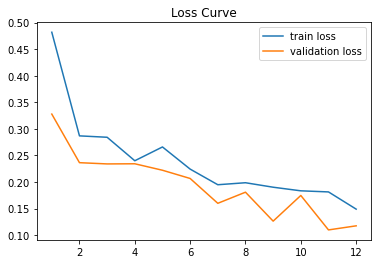

In [24]:
"""
Plot the loss curve
"""
plt.title("Loss Curve")
plt.plot([*range(1,epochs+1)], train_loss_list)
plt.plot([*range(1,epochs+1)], validation_loss_list)
plt.legend(['train loss','validation loss'])
plt.show()

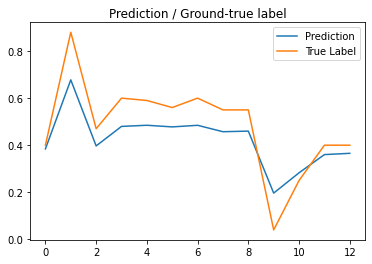

In [25]:
"""
Plot prediction / ground-true label
"""
plt.title("Prediction / Ground-true label")
plt.plot(label_pred)
plt.plot(label_true)
plt.legend(['Prediction','True Label'])
plt.show()